### The University of Melbourne, School of Computing and Information Systems
# COMP90086 Computer Vision, 2023 Semester 2

## Assignment 1

**Student Name:**    `Jiaheng Dong`

**Student ID:**     `1166436`

This iPython notebook is a template which you should use for your Assignment 1 submission. This file should be submitted at the **Assignment 1** link on the LMS, along with any images needed to run your code.

In addition to this file, you should submit a written report explaining your results at the **Assignment 1** link on the LMS. Please see the assignment specification for details on what must be included in the report for each question.

*Adding proper comments to your code is MANDATORY.*

### 0. Laplacian pyramid compression
You can use the code below to check how much a quantized Laplacian pyramid representation compresses an image.

In [1]:
imSize = 256 # image height/width (assume image is square)
bitsPerLevel = [2,3,4,5,6,7,8] # bits used to encode each level of pyramid

# Image size before compression, in bits (assume uint8 grayscale)
sizeUncompressed = 8 * imSize * imSize
print('Uncompressed size = '+str(sizeUncompressed)+' bits')

# Image size after compression, in bits
sizeCompressed = 0
for i in range(len(bitsPerLevel)):
    sizeCompressed = sizeCompressed + (bitsPerLevel[i]*(imSize/(pow(2,i)))*(imSize/(pow(2,i))))
print('Compressed size = '+str(sizeCompressed)+' bits')

print(str(round(100*sizeCompressed/sizeUncompressed))+'% of original')

Uncompressed size = 524288 bits
Compressed size = 203840.0 bits
39% of original


### 1. Laplacian image pyramid

In [336]:
import numpy as np
import cv2
# Define the filter kernel
kernel = (1/256)*np.array([[1, 4, 6, 4, 1],
                           [4, 16, 24, 16, 4],
                           [6, 24, 36, 24, 6],
                           [4, 16, 24, 16, 4],
                           [1, 4, 6, 4, 1]])
def get_upsampled_img(height, width, downsampled_img):
    upsampled_img = np.zeros((height*2, width*2))
    for row in range(0,height):
        for column in range(0,width):
            upsampled_img[::2,::2][row][column] = downsampled_img[row][column]
    return upsampled_img    

def create_Laplacian_pyramid(img, levels):
    pyramid_imgs = []
    for i in range(0, levels):
        if i < levels-1:
            gau_out_d = cv2.filter2D(img, -1, kernel)
            downsampled_img = gau_out_d[::2, ::2]
            height_d = len(downsampled_img)
            width_d = len(downsampled_img[0])
            upsampled_img = get_upsampled_img(height_d, width_d, downsampled_img)
            gau_out_u = cv2.filter2D(upsampled_img, -1, 4*kernel)
            pyramid_imgs.append(img - gau_out_u)
            img = downsampled_img
            i+=1
        else:
            pyramid_imgs.append(img)
            i+=1
    return pyramid_imgs

def recreating_img(pyramid_imgs):
    levels = len(pyramid_imgs)
    img = pyramid_imgs[levels-1]
    for i in range(0, levels-1):
        height = len(img)
        width = len(img[0])
        upsampled_img = get_upsampled_img(height, width, img)
        gau_out_u = cv2.filter2D(upsampled_img, -1, 4*kernel)
        img = gau_out_u + pyramid_imgs[levels - 2 - i]
        i+=1
    return img

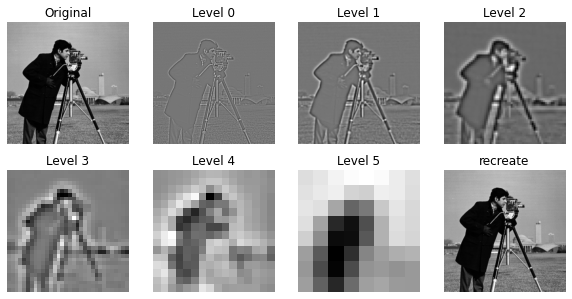

In [337]:
#used for display the Laplacian pyramid
from matplotlib import pyplot as plt
import os
rootpath='./'
test_img= cv2.imread(os.path.join(rootpath, "cameraman.png"),cv2.IMREAD_GRAYSCALE) 
#define the level
levels = 6
pyramid = create_Laplacian_pyramid(test_img, levels)
recreate_img = recreating_img(pyramid)

plt.figure(figsize=(10, 5))
plt.subplot(2,4,1)
plt.imshow(test_img,cmap='gray') 
plt.title('Original')
plt.axis('off')

i = 1
while i < 7:
    plt.subplot(2, 4, i + 1)
    plt.imshow(pyramid[i-1], cmap='gray')
    plt.title(f'Level {i-1}')
    plt.axis('off')
    i += 1

plt.subplot(2,4,8)
plt.imshow(recreate_img,cmap='gray') 
plt.title('recreate')
plt.axis('off')
plt.show()

### 2. Quantization and compression

In [338]:
def quantize_an_image(img, bins):
    bins_num = 2 ** bins
    height = len(img)
    width = len(img[0])
    flat_img = np.array(img.flatten())
    elements, intervels = pd.qcut(flat_img, q = bins_num, retbins=True, duplicates='drop')
    i = 0
    while i < len(intervels)-1:
        if len(flat_img[(flat_img > intervels[i]) & (flat_img <= intervels[i+1])]) != 0:
            flat_img[(flat_img > intervels[i]) & (flat_img <= intervels[i+1])] = flat_img[(flat_img > intervels[i]) & (flat_img <= intervels[i+1])].mean()
        i+=1
    quantized_img = flat_img.reshape((height, width))
    return quantized_img
    

In [339]:
#used for display the quantization and compression
rootpath='./'
test_img_2= cv2.imread(os.path.join(rootpath, "cat.png"),cv2.IMREAD_GRAYSCALE) 

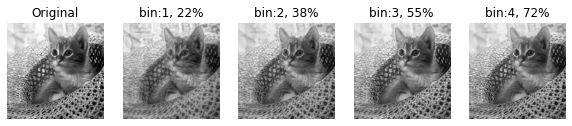

In [340]:
#original image
plt.figure(figsize=(10, 5))
plt.subplot(1,5,1)
plt.imshow(test_img_2,cmap='gray') 
plt.title('Original')
plt.axis('off')

sizeUncompressed = 8 * test_img_2.size
# Image size after compression, in bits
#define the level
levels = 5
pyramid = create_Laplacian_pyramid(test_img_2, levels)

#to show the same pyramid level with 
#different bins, and the bin is increasing by 1 in each layer
bins_1 = [1,2,3,4]
k = 0
new_pyramid = pyramid.copy()
while k < len(new_pyramid) - 1:
    new_pyramid[k] = quantize_an_image(new_pyramid[k], bins_1[k])
    k+=1
recreate_img = recreating_img(new_pyramid)
sizeCompressed = 0
for i in range(len(bins_1)):
    sizeCompressed = sizeCompressed + (bins_1[i]*(imSize/((pow(2,i))**2)))                                       
plt.subplot(1,5,2)
plt.imshow(recreate_img,cmap='gray') 
plt.title(f'bin:1, {str(round(100*sizeCompressed/sizeUncompressed))}%')
plt.axis('off')

bins_2 = [2,3,4,5]
k = 0
new_pyramid = pyramid.copy()
while k < len(new_pyramid) - 1:
    new_pyramid[k] = quantize_an_image(new_pyramid[k], bins_2[k])
    k+=1
chosen_recreate_img = recreating_img(new_pyramid)
sizeCompressed = 0
for i in range(len(bins_2)):
    sizeCompressed = sizeCompressed + (bins_2[i]*(imSize/((pow(2,i))**2)))                                       
plt.subplot(1,5,3)
plt.imshow(chosen_recreate_img,cmap='gray') 
plt.title(f'bin:2, {str(round(100*sizeCompressed/sizeUncompressed))}%')
plt.axis('off')

bins_3 = [3,4,5,6]
k = 0
new_pyramid = pyramid.copy()
while k < len(new_pyramid) - 1:
    new_pyramid[k] = quantize_an_image(new_pyramid[k], bins_3[k])
    k+=1
recreate_img = recreating_img(new_pyramid)
sizeCompressed = 0
for i in range(len(bins_3)):
    sizeCompressed = sizeCompressed + (bins_3[i]*(imSize/((pow(2,i))**2)))                                       
plt.subplot(1,5,4)
plt.imshow(recreate_img,cmap='gray') 
plt.title(f'bin:3, {str(round(100*sizeCompressed/sizeUncompressed))}%')
plt.axis('off')

bins_4 = [4,5,6,7]
k = 0
new_pyramid = pyramid.copy()
while k < len(pyramid) - 1:
    new_pyramid[k] = quantize_an_image(new_pyramid[k], bins_4[k])
    k+=1
recreate_img = recreating_img(new_pyramid)
sizeCompressed = 0
for i in range(len(bins_4)):
    sizeCompressed = sizeCompressed + (bins_4[i]*(imSize/((pow(2,i))**2)))                                       
plt.subplot(1,5,5)
plt.imshow(recreate_img,cmap='gray') 
plt.title(f'bin:4, {str(round(100*sizeCompressed/sizeUncompressed))}%')
plt.axis('off')
plt.show()

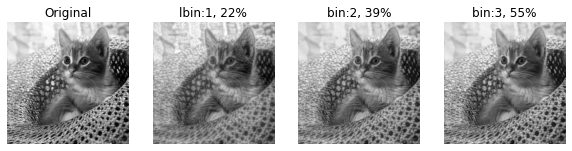

In [341]:
#for level 6
#original image
plt.figure(figsize=(10, 5))
plt.subplot(1,4,1)
plt.imshow(test_img_2,cmap='gray') 
plt.title('Original')
plt.axis('off')

sizeUncompressed = 8 * test_img_2.size
# Image size after compression, in bits
#define the level
levels = 6
pyramid = create_Laplacian_pyramid(test_img_2, levels)

#to show the same pyramid level with 
#different bins, and the bin is increasing by 1 in each layer
bins_1 = [1,2,3,4,5]
k = 0
new_pyramid = pyramid.copy()
while k < len(new_pyramid) - 1:
    new_pyramid[k] = quantize_an_image(new_pyramid[k], bins_1[k])
    k+=1
recreate_img = recreating_img(new_pyramid)
sizeCompressed = 0
for i in range(len(bins_1)):
    sizeCompressed = sizeCompressed + (bins_1[i]*(imSize/((pow(2,i))**2)))                                       
plt.subplot(1,4,2)
plt.imshow(recreate_img,cmap='gray') 
plt.title(f'lbin:1, {str(round(100*sizeCompressed/sizeUncompressed))}%')
plt.axis('off')

bins_2 = [2,3,4,5,6]
k = 0
new_pyramid = pyramid.copy()
while k < len(new_pyramid) - 1:
    new_pyramid[k] = quantize_an_image(new_pyramid[k], bins_2[k])
    k+=1
recreate_img = recreating_img(new_pyramid)
sizeCompressed = 0
for i in range(len(bins_2)):
    sizeCompressed = sizeCompressed + (bins_2[i]*(imSize/((pow(2,i))**2)))                                       
plt.subplot(1,4,3)
plt.imshow(recreate_img,cmap='gray') 
plt.title(f'bin:2, {str(round(100*sizeCompressed/sizeUncompressed))}%')
plt.axis('off')

bins_3 = [3,4,5,6,7]
k = 0
new_pyramid = pyramid.copy()
while k < len(new_pyramid) - 1:
    new_pyramid[k] = quantize_an_image(new_pyramid[k], bins_3[k])
    k+=1
recreate_img = recreating_img(new_pyramid)
sizeCompressed = 0
for i in range(len(bins_3)):
    sizeCompressed = sizeCompressed + (bins_3[i]*(imSize/((pow(2,i))**2)))                                       
plt.subplot(1,4,4)
plt.imshow(recreate_img,cmap='gray') 
plt.title(f'bin:3, {str(round(100*sizeCompressed/sizeUncompressed))}%')
plt.axis('off')
plt.show()

### 3. Evaluation in the frequency domain

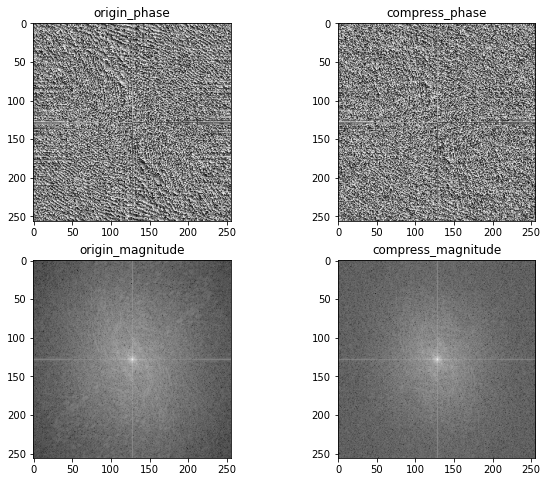

In [335]:
#fourier transform of the orignal image
origin_f = np.fft.fft2(test_img_2)
origin_f = np.fft.fftshift(origin_f)
origin_phase = np.angle(origin_f)
origin_magnitude = np.abs(origin_f)

#fourier transform of the compressed image
compress_f = np.fft.fft2(chosen_recreate_img)
compress_f = np.fft.fftshift(compress_f)
compress_phase = np.angle(compress_f)
compress_magnitude = np.abs(compress_f)

#plot the phase and magnitude
plt.figure(figsize=(10, 8))

plt.subplot(2,2,1)
plt.imshow(origin_phase,cmap='gray') 
plt.title('origin_phase')

plt.subplot(2,2,2)
plt.imshow(compress_phase,cmap='gray') 
plt.title('compress_phase')

plt.subplot(2,2,3)
plt.imshow(np.log(origin_magnitude),cmap='gray') 
plt.title('origin_magnitude')

plt.subplot(2,2,4)
plt.imshow(np.log(compress_magnitude),cmap='gray') 
plt.title('compress_magnitude')
plt.show()